# Υπερεκπαιδεύοντας τα Σπίτια

---

> Πάνος Λουρίδας, Αναπληρωτής Καθηγητής <br />
> Τμήμα Διοικητικής Επιστήμης και Τεχνολογίας <br />
> Οικονομικό Πανεπιστήμιο Αθηνών <br />
> louridas@aueb.gr

In [1]:
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

tf.random.set_seed(0) # for replicability purposes, not for production

* Για να δούμε πώς μπορούμε να κάνουμε πρόβλεψη μιας αριθμητικής τιμής, θα επιστρέψουμε στο γνώριμό μας σύνολο δεδομένων με τα σπίτια από την Καλιφόρνια.

In [2]:
california = fetch_california_housing(as_frame=True)
california.data

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25
...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32


* Θα τα χωρίσουμε σε δεδομένα εκπαίδευσης και ελέγχου.

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(california.data, 
                                                    california.target, 
                                                    test_size=0.20,
                                                    random_state=13)

* Θυμηθείτε ότι πρέπει να κανονικοποιήσουμε τα δεδομένα.

* Για το σκοπό αυτό μπορούμε στο TensorFlow να χρησιμοποιήσουμε το ειδικό στρώμα `Normalization`.

* Αυτό το χρησιμοποιούμε χρησιμοποιώντας τη μέθοδο `adapt()` στα δεδομένα εκπαίδευσης.

* Τότε θα διαβάσει τα δεδομένα και θα υπολογίσει το μέσο όρο, τη διακύμανση, και τον αριθμό των δεδομένων, για κάθε στήλη.

In [4]:
normalizer = layers.Normalization()
normalizer.adapt(np.array(X_train))
with np.printoptions(precision=2):
    print(normalizer.mean.numpy())
    print(normalizer.variance.numpy())
    print(normalizer.count.numpy())

[[ 3.86e+00  2.87e+01  5.43e+00  1.10e+00  1.43e+03  3.10e+00  3.57e+01
  -1.20e+02]]
[[3.58e+00 1.58e+02 6.53e+00 2.43e-01 1.33e+06 1.34e+02 4.60e+00 4.04e+00]]
16512


* Ξεκινάμε με ένα μοντέλο με 32 νευρώνες σε ένα κρυμμένο στρώμα και έναν νευρώνα στο στρώμα εξόδου.

* Δεν δίνουμε συνάρτηση ενεργοποίησης στο στρώμα εξόδου αφού θέλουμε να προβλέψουμε την τιμή του σπιτιού, άρα να πάρουμε το αποτέλεσμα του νευρώνα χωρίς να το υποχρεώνουμε να είναι σε κάποια όρια τιμών.

* Την απώλεια θα την μετράμε με βάση το Μέσο Απόλυτο Λάθος.

In [5]:
model = keras.Sequential([
        normalizer,
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])

model.compile(loss='mean_absolute_error',
              optimizer=tf.keras.optimizers.Adam(0.001))

* Να το δούμε συνοπτικά.

* Παρατηρείστε ότι έχουμε παραμέτρους που δεν εκπαιδεύονται: είναι οι μέσοι όροι, οι διακυμάνσεις, και ο αριθμός των στοιχείων που έχει ήδη βρει το επίπεδο `Normalization`.

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 8)                17        
 n)                                                              
                                                                 
 dense (Dense)               (None, 32)                288       
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 338
Trainable params: 321
Non-trainable params: 17
_________________________________________________________________


* Θα εκπαιδεύσουμε το μοντέλο μας για 100 εποχές.

* Σε κάθε εποχή τα τελευταία 20% των δεδομένων θα χρησιμοποιούνται για επικύρωση.

* Θα αποθηκεύσουμε την πορεία της εκπαίδευσης σε μία μεταβλητή `history`.

In [7]:
num_epochs = 100

history = model.fit(
    X_train, 
    y_train,
    epochs=num_epochs, 
    validation_split=0.2,
    verbose=1)

Epoch 1/100
413/413 [==============================] - 3s 4ms/step - loss: 0.8047 - val_loss: 0.5796
Epoch 2/100
413/413 [==============================] - 1s 4ms/step - loss: 0.5087 - val_loss: 0.4928
Epoch 3/100
413/413 [==============================] - 1s 3ms/step - loss: 0.4637 - val_loss: 0.4640
Epoch 4/100
413/413 [==============================] - 1s 3ms/step - loss: 0.4462 - val_loss: 0.4573
Epoch 5/100
413/413 [==============================] - 2s 4ms/step - loss: 0.4370 - val_loss: 0.4532
Epoch 6/100
413/413 [==============================] - 1s 3ms/step - loss: 0.4323 - val_loss: 0.4418
Epoch 7/100
413/413 [==============================] - 1s 3ms/step - loss: 0.4275 - val_loss: 0.4401
Epoch 8/100
413/413 [==============================] - 2s 4ms/step - loss: 0.4243 - val_loss: 0.4356
Epoch 9/100
413/413 [==============================] - 1s 3ms/step - loss: 0.4203 - val_loss: 0.4366
Epoch 10/100
413/413 [==============================] - 2s 4ms/step - loss: 0.4175 - val_lo

* Η πορεία της εκπαίδευσης μας δείχνει την πρόοδο στην απώλεια εκπαίδευσης και στην απώλεια επικύρωσης, σε κάθε εποχή.

In [8]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist

,loss,val_loss,epoch
0,0.804669,0.579563,0
1,0.508653,0.492838,1
2,0.463731,0.463953,2
3,0.446166,0.457256,3
4,0.436963,0.453202,4
...,...,...,...
95,0.364532,0.380361,95
96,0.363425,0.387689,96
97,0.363332,0.382579,97
98,0.363485,0.380733,98


* Μπορούμε να δούμε την εξέλιξη αν φτιάξουμε μια βοηθητική συνάρτηση για την απεικόνιση.

In [9]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

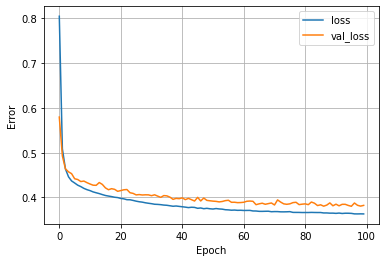

In [10]:
plot_loss(history)

* Βλέπουμε ότι η απώλεια στην επικύρωση αποκλίνει από την απώλεια εκπαίδευσης.

* Αυτό μπορεί να είναι δείγμα υπερπροσαρμογής.

* Αξιολογούμε το μοντέλο μας με βάση τα δεδομένα ελέγχου.

In [11]:
model.evaluate(X_test, y_test, verbose=0)

0.3827310800552368

* Ας δούμε αν θα τα πάμε καλύτερα με ένα μεγαλύτερο δίκτυο.

In [12]:
model = keras.Sequential([
        normalizer,
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])

model.compile(loss='mean_absolute_error',
              optimizer=tf.keras.optimizers.Adam(0.001))

* Συνοπτικά:

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 8)                17        
 n)                                                              
                                                                 
 dense_2 (Dense)             (None, 64)                576       
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,706
Trainable params: 2,689
Non-trainable params: 17
_________________________________________________________________


* Εκπαιδεύουμε:

In [14]:
history = model.fit(
    X_train, 
    y_train,
    epochs=num_epochs, 
    validation_split=0.2,
    verbose=1)

Epoch 1/100
413/413 [==============================] - 2s 4ms/step - loss: 0.6449 - val_loss: 0.4896
Epoch 2/100
413/413 [==============================] - 1s 3ms/step - loss: 0.4441 - val_loss: 0.4435
Epoch 3/100
413/413 [==============================] - 1s 3ms/step - loss: 0.4193 - val_loss: 0.4303
Epoch 4/100
413/413 [==============================] - 2s 4ms/step - loss: 0.4072 - val_loss: 0.4200
Epoch 5/100
413/413 [==============================] - 1s 3ms/step - loss: 0.3930 - val_loss: 0.4068
Epoch 6/100
413/413 [==============================] - 1s 4ms/step - loss: 0.3848 - val_loss: 0.3959
Epoch 7/100
413/413 [==============================] - 2s 4ms/step - loss: 0.3769 - val_loss: 0.3937
Epoch 8/100
413/413 [==============================] - 1s 3ms/step - loss: 0.3736 - val_loss: 0.3836
Epoch 9/100
413/413 [==============================] - 1s 3ms/step - loss: 0.3674 - val_loss: 0.3798
Epoch 10/100
413/413 [==============================] - 1s 3ms/step - loss: 0.3645 - val_lo

* Η αξιολόγησή του:

In [15]:
model.evaluate(X_test, y_test, verbose=0)

0.34064018726348877

* Τα πήγαμε μεν καλύτερα, αλλά οι δύο απώλειες άρχισαν να αποκλίνουν νωρίτερα.

* Επίσης, η απώλεια επικύρωσης δεν φαίνεται να βελτιώνεται σημαντικά από ένα σημείο και μετά.

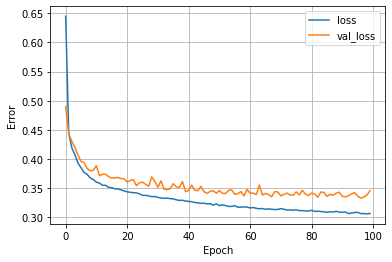

In [16]:
plot_loss(history)

* Προκειμένου να μην χάνουμε το χρόνο μας εκπαιδεύοντας το δίκτυο σε περισσότερες εποχές από όσες χρειάζεται, μπορούμε να χρησιμοποιήσουμε έναν μηχανισμό για πρόωρη διακοπή.

* Η εκπαίδευση θα διακοπεί αν δεν σημειωθεί βελτίωση σε δέκα εποχές.

In [17]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

* Ξαναφτιάχνουμε το μοντέλο μας.

In [18]:
model = keras.Sequential([
        normalizer,
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])

model.compile(loss='mean_absolute_error',
              optimizer=tf.keras.optimizers.Adam(0.001))

* Αυτή τη φορά του δίνουμε τον κανόνα πρόωρης διακοπής μέσω της παραμέτρου `callbacks`.

In [19]:
history = model.fit(
    X_train, 
    y_train,
    epochs=num_epochs, 
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stop])

Epoch 1/100
413/413 [==============================] - 2s 3ms/step - loss: 0.5950 - val_loss: 0.4631
Epoch 2/100
413/413 [==============================] - 1s 2ms/step - loss: 0.4354 - val_loss: 0.4421
Epoch 3/100
413/413 [==============================] - 1s 3ms/step - loss: 0.4186 - val_loss: 0.4324
Epoch 4/100
413/413 [==============================] - 1s 3ms/step - loss: 0.4115 - val_loss: 0.4242
Epoch 5/100
413/413 [==============================] - 1s 2ms/step - loss: 0.4023 - val_loss: 0.4149
Epoch 6/100
413/413 [==============================] - 1s 3ms/step - loss: 0.3943 - val_loss: 0.4066
Epoch 7/100
413/413 [==============================] - 1s 3ms/step - loss: 0.3884 - val_loss: 0.4101
Epoch 8/100
413/413 [==============================] - 1s 3ms/step - loss: 0.3839 - val_loss: 0.3975
Epoch 9/100
413/413 [==============================] - 1s 2ms/step - loss: 0.3796 - val_loss: 0.3927
Epoch 10/100
413/413 [==============================] - 1s 2ms/step - loss: 0.3748 - val_lo

* Πράγματι, σταματήσαμε πριν από τις 80 εποχές.

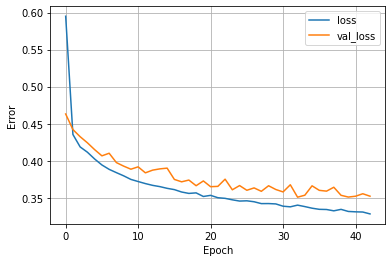

In [20]:
plot_loss(history)

* Η δε επίδοση του μοντέλου δεν επηρεάστηκε σημαντικά.

In [21]:
model.evaluate(X_test, y_test, verbose=0)

0.3531564176082611

* Ας φτιάξουμε τότε ένα ακόμα μεγαλύτερο μοντέλο να δούμε αν θα τα πάμε ακόμα καλύτερα.

In [22]:
model = keras.Sequential([
        normalizer,
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

model.compile(loss='mean_absolute_error',
              optimizer=tf.keras.optimizers.Adam(0.001))

* Εκπαιδεύουμε:

In [23]:
history = model.fit(
    X_train, 
    y_train,
    epochs=num_epochs, 
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stop])

Epoch 1/100
413/413 [==============================] - 2s 3ms/step - loss: 0.5739 - val_loss: 0.4513
Epoch 2/100
413/413 [==============================] - 1s 3ms/step - loss: 0.4288 - val_loss: 0.4314
Epoch 3/100
413/413 [==============================] - 1s 3ms/step - loss: 0.4125 - val_loss: 0.4230
Epoch 4/100
413/413 [==============================] - 1s 3ms/step - loss: 0.4020 - val_loss: 0.4321
Epoch 5/100
413/413 [==============================] - 1s 3ms/step - loss: 0.3880 - val_loss: 0.4036
Epoch 6/100
413/413 [==============================] - 1s 3ms/step - loss: 0.3791 - val_loss: 0.3898
Epoch 7/100
413/413 [==============================] - 1s 3ms/step - loss: 0.3718 - val_loss: 0.3922
Epoch 8/100
413/413 [==============================] - 1s 3ms/step - loss: 0.3678 - val_loss: 0.3788
Epoch 9/100
413/413 [==============================] - 1s 3ms/step - loss: 0.3625 - val_loss: 0.3811
Epoch 10/100
413/413 [==============================] - 1s 3ms/step - loss: 0.3600 - val_lo

* Η απόκλιση μεταξύ των απωλειών μεγάλωσε ακόμα περισσότερο.

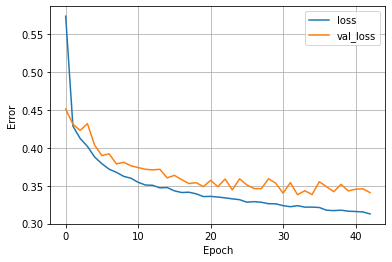

In [24]:
plot_loss(history)

* Η δε επίδοση έμεινε στα ίδια επίπεδα.

In [25]:
model.evaluate(X_test, y_test, verbose=0)

0.34105488657951355

* Και αν το μεγαλώσουμε ακόμα περισσότερο;

In [26]:
model = keras.Sequential([
        normalizer,
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

model.compile(loss='mean_absolute_error',
              optimizer=tf.keras.optimizers.Adam(0.001))

* Εκπαιδεύουμε:

In [27]:
history = model.fit(
    X_train, 
    y_train,
    epochs=num_epochs, 
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stop])

Epoch 1/100
413/413 [==============================] - 3s 4ms/step - loss: 0.5213 - val_loss: 0.4465
Epoch 2/100
413/413 [==============================] - 2s 4ms/step - loss: 0.4194 - val_loss: 0.4193
Epoch 3/100
413/413 [==============================] - 1s 3ms/step - loss: 0.3935 - val_loss: 0.3964
Epoch 4/100
413/413 [==============================] - 1s 4ms/step - loss: 0.3804 - val_loss: 0.4294
Epoch 5/100
413/413 [==============================] - 2s 4ms/step - loss: 0.3718 - val_loss: 0.3982
Epoch 6/100
413/413 [==============================] - 1s 3ms/step - loss: 0.3650 - val_loss: 0.3783
Epoch 7/100
413/413 [==============================] - 1s 3ms/step - loss: 0.3607 - val_loss: 0.3813
Epoch 8/100
413/413 [==============================] - 2s 4ms/step - loss: 0.3559 - val_loss: 0.3679
Epoch 9/100
413/413 [==============================] - 1s 4ms/step - loss: 0.3510 - val_loss: 0.3679
Epoch 10/100
413/413 [==============================] - 1s 3ms/step - loss: 0.3455 - val_lo

* Εδώ κι αν μεγάλωσε η απόκλιση!

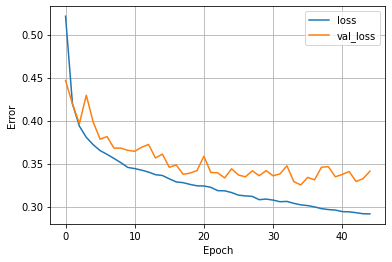

In [28]:
plot_loss(history)

* Και η επίδοση στα ίδια (ή μάλλον ανεπαίσθητα χειρότερα).

In [29]:
model.evaluate(X_test, y_test, verbose=0)

0.3379669785499573

* Γιατί συμβαίνει αυτό;

* Ας δούμε το μοντέλο.

In [30]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 8)                17        
 n)                                                              
                                                                 
 dense_11 (Dense)            (None, 256)               2304      
                                                                 
 dense_12 (Dense)            (None, 128)               32896     
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dense_14 (Dense)            (None, 1)                 65        
                                                                 
Total params: 43,538
Trainable params: 43,521
Non-trainable params: 17
_________________________________________________

* Έχουμε φτιάξει ένα μοντέλο που έχει περισσότερες παραμέτρους από όσα είναι τα δείγματά μας.

* Το μοντέλο παραείναι ισχυρό για τα δεδομένα που έχουμε στη διάθεσή μας.

* Ένα τέτοιο μοντέλο μπορεί να πέσει θύμα της υπερπροσαρμογής.

In [31]:
model.count_params()

43538

* Προσοχή! Όταν φτιάχνουμε νευρωνικά δίκτυα, δεν προσθέτουμε τυφλά στρώματα και νευρώνες.

* Τελικά αυτό που θα πετύχουμε είναι να φτιάξουμε ένα δίκτυο με τόσους νευρώνες και συνδέσεις ώστε πολύ γρήγορα θα αρχίσει να παπαγαλίζει τα δεδομένα.

* Πρέπει να διαστασιολογούμε το δίκτυο με βάση τον όγκο των δεδομένων του προβλήματός μας.

* Τα αποτελέσματα είναι αντίστοιχα (ίσως λίγο χειρότερα, αλλά δεν ψάξαμε τις υπερπαραμέτρους) με αυτά που πετύχαμε μέσω δένδρων αποφάσεων.

* Όπως μπορούμε να διαπιστώσουμε όμως, η εκπαίδευση των νευρωνικών δικτύων μπορεί να χρειάζεται περισσότερους πόρους.

* Επίσης όπως μπορούμε να διαπιστώσουμε, δεν έχουμε την ερμηνευσιμότητα που μπορούμε να έχουμε με άλλες μεθόδους.